In [1]:
import os
#Defaults to 0, so all logs are shown.
#Set TF_CPP_MIN_LOG_LEVEL to 1 to filter out INFO logs
#2 to additionally filter out WARNING,
#3 to additionally filter out ERROR.
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"
import json

In [2]:
#Get keywords dict, also a reversed ver. of dict
#There is no key for value 41 due to an error?

keywordsfile = "keywordsdict.txt"
kfdread = open(keywordsfile,"r")
keywords = json.load(kfdread)
kfdread.close()

print(len(keywords))

valtokeyw = {v: k for k, v in keywords.items()}


123


In [3]:
import numpy
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from keras.layers import LSTM
from keras.layers.core import Dense
#from keras.preprocessing import sequence
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from numpy.random import seed

seed(1)

dataset = pd.read_csv('vectors9.csv')
y = dataset.iloc[:, 0].values
x = dataset.iloc[:, 1:].values

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/opt/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
n_labels = len(keywords)+2

x1 = numpy.eye(n_labels)[x]

In [5]:
print(x1.ndim)
print(y.ndim)

print(x1.shape)
print(y.shape)

3
1
(14214, 200, 125)
(14214,)


In [6]:
#from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_sample_weight

calculated_weight = compute_sample_weight(class_weight='balanced',y=y)

print(y[0])
print(calculated_weight[0])

print(y[101])
print(calculated_weight[101])

#class_weight = {0:9.897350993377483,1:0.5266032417195208}
#class_weight = {0:0.7590567825643268,1:1.4650393922341025}

#Splitting to training and test sets
x_train, x_test, y_train, y_test = train_test_split(x1, y, test_size=0.3, random_state=42)

0
1.0
0
1.0


# LSTM Model

In [24]:
import functools
from keras import backend as K
import tensorflow as tf

def as_keras_metric(method):
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

precision = as_keras_metric(tf.metrics.precision)
recall = as_keras_metric(tf.metrics.recall)

@as_keras_metric
def auc_pr(y_true, y_pred, curve='PR'):
    return tf.metrics.auc(y_true, y_pred, curve=curve)

In [28]:
from keras import regularizers
from keras.layers import Dropout

feature_size = x1.shape[-1]
model = Sequential()
model.add(LSTM(100, input_shape=(200, feature_size)))
#model.add(Conv1D(64,kernel_size=1,input_shape=(200, feature_size)))
#model.add(Dense(feature_size,activation='relu'))
model.add(Dense(100, input_dim=feature_size,
                kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))
#model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[precision,recall])

model.summary()
history = model.fit(x_train, y_train, epochs=300, batch_size=512, verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               90400     
_________________________________________________________________
dense_11 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 101       
Total params: 100,601
Trainable params: 100,601
Non-trainable params: 0
_________________________________________________________________


# Conv1D Model

In [28]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras import regularizers

feature_size = x1.shape[-1]
model = Sequential()
model.add(Conv1D(700, 3, activation='elu', input_shape=(200, feature_size)))
model.add(Conv1D(512, 3, activation='elu'))
print(model.input_shape)
print(model.output_shape)
model.add(MaxPooling1D(pool_size = (15), strides=(10)))
print(model.output_shape)
model.add(Conv1D(256, 3))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l1(0.01)))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=512, validation_split=0.3, epochs=200,verbose=0)
#score = model.evaluate(x_test, y_test, batch_size=16)
model.summary()

(None, 200, 125)
(None, 196, 512)
(None, 19, 512)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_22 (Conv1D)           (None, 198, 700)          263200    
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 196, 512)          1075712   
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 19, 512)           0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 17, 256)           393472    
_________________________________________________________________
global_average_pooling1d_8 ( (None, 256)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)           

# Graph

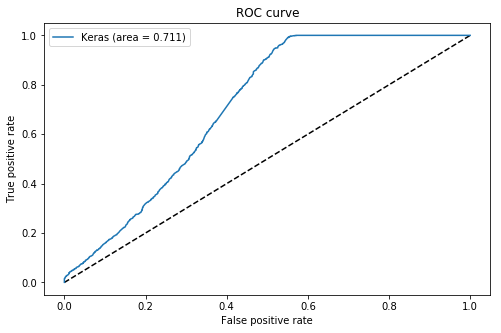

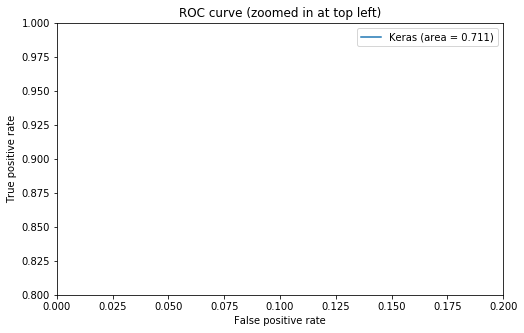

In [29]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

y_pred_keras = model.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

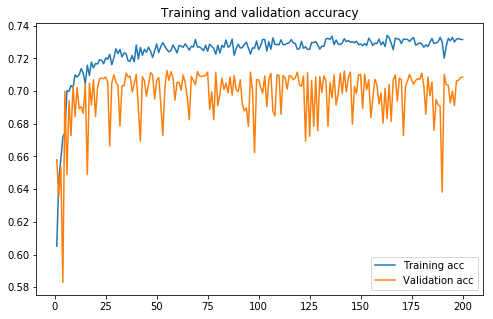

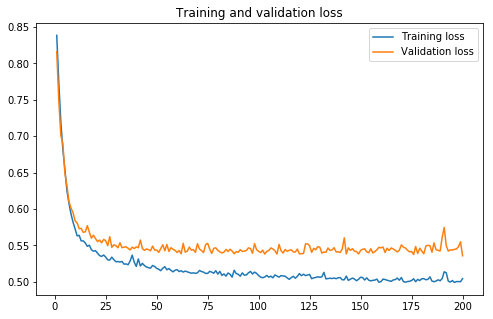

In [30]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.rcParams["figure.figsize"] = (8,5)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [83]:
# evaluate the model
scores = model.evaluate(x_test, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

4265/4265 [==============================] - 1s 213us/step

acc: 71.42%


In [84]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [44]:
from keras.models import model_from_json

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [45]:
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

acc: 70.72%


In [18]:
testset = pd.read_csv('vector.csv',header=None)
testx = testset.iloc[:, 0:].values

testx1 = numpy.eye(n_labels)[testx]

testy = model.predict_classes(testx1)
probability = model.predict_proba(testx1)

#print(testx)

print(testx1.shape)
print(testy.shape)

for i in range(0,len(testy)):
    print("X=%s, Predicted=%s" % (testx1[i], testy[i]))
    print("Probability=%s"%(probability[i]))

(4, 200, 125)
(4, 1)
X=[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]], Predicted=[1]
Probability=[0.5263393]
X=[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]], Predicted=[1]
Probability=[0.5263393]
X=[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]], Predicted=[0]
Probability=[0.00233869]
X=[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]], Predicted=[0]
Probability=[0.4856821]


In [ ]:
#Creating csv file, pad zeroes/cut data

import csv

total = 0
count = 0
fixedsize = 170
good = "0"
bad = "1"

#Function to pad zeroes
def trp(l, n):
    return l[:n] + [0]*(n-len(l))

with open("goodvectors.txt","r") as good_file:
    #stripped = (line.strip() for line in good_file)
    #lines = (line.split(",") for line in stripped if line)
    lines = [line.strip() for line in good_file]
    with open("vectors.csv","a") as out_file:
        codewriter = csv.writer(out_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        for line in lines:
            templist = [x.strip() for x in line.split(',')]
            tempstr = ''
            
            #Make the size of templist to be fixedsize
            if (len(templist)<fixedsize):
                templist = trp(templist,fixedsize)
            elif (len(templist)>fixedsize):
                templist = templist[:fixedsize]
            print(len(templist))
            for i in range(0,len(templist)-1):
                tempstr = tempstr + str(templist[i])+","
            tempstr = tempstr + str(templist[len(templist)-1])
            
            templist2 = []
            templist2.insert(0,good) #Toggle between good/bad according to source file
            templist2.insert(1,tempstr)
            codewriter.writerow(templist2)


In [2]:
#Creating csv file, pad zeroes/cut data
#VERSION 2

import csv

total = 0
count = 0
fixedsize = 170
good = "0"
bad = "1"

#Function to pad zeroes
def trp(l, n):
    return l[:n] + [0]*(n-len(l))

with open("badvectors.txt","r") as good_file:
    #stripped = (line.strip() for line in good_file)
    #lines = (line.split(",") for line in stripped if line)
    lines = [line.strip() for line in good_file]
    with open("vectors4.csv","a") as out_file:
        codewriter = csv.writer(out_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        for line in lines:
            templist = [int(x.strip()) for x in line.split(',')]
            
            #Make the size of templist to be fixedsize
            if (len(templist)<fixedsize):
                templist = trp(templist,fixedsize)
            elif (len(templist)>fixedsize):
                templist = templist[:fixedsize]
            
            templist.insert(0,bad) #Toggle between good/bad according to source file
            codewriter.writerow(templist)


In [22]:
#For testvector.txt

import csv

total = 0
count = 0
fixedsize = 170

#Function to pad zeroes
def trp(l, n):
    return l[:n] + [0]*(n-len(l))

with open("testvector.txt","r") as good_file:
    #stripped = (line.strip() for line in good_file)
    #lines = (line.split(",") for line in stripped if line)
    lines = [line.strip() for line in good_file]
    with open("testvector.csv","w") as out_file:
        codewriter = csv.writer(out_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        for line in lines:
            templist = [int(x.strip()) for x in line.split(',')]
            
            #Make the size of templist to be fixedsize
            if (len(templist)<fixedsize):
                templist = trp(templist,fixedsize)
            elif (len(templist)>fixedsize):
                templist = templist[:fixedsize]
            
            codewriter.writerow(templist)

In [1]:
# Importing dependencies numpy and keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/opt/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
df = pd.read_csv('vectors9.csv',delimiter=',',encoding='latin-1')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14214 entries, 0 to 14213
Columns: 201 entries, type to Unnamed: 200
dtypes: int64(201)
memory usage: 21.8 MB


Text(0.5,1,'Number of good codes (0) and bad codes (1) in the test data')

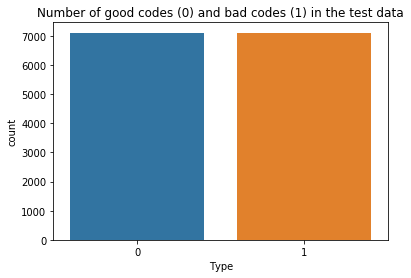

In [3]:
sns.countplot(df.type)
plt.xlabel('Type')
plt.title('Number of good codes (0) and bad codes (1) in the test data')

# The codes below are used for miscellaneous testing.

These codes should not be executed when formally processing data.

In [ ]:
#Function to get assembly code from vectors

def getAssemFromVect():
    keywordsfile = "keywordsdict.txt"
    kfdread = open(keywordsfile,"r+")
    keywords = json.load(kfdread)
    kfdread.close()
    wordslist = []
    randomfile = "/home/osboxes/Workfiles/goodvectors.txt"
    with open(randomfile) as file:
        lines = [line.strip() for line in file]
    for line in lines:
        templist = [x.strip() for x in line.split(',')]
        for item in templist:
            for keyword, value in keywords.items():
                #print("item: "+item)
                #print("value: "+value)
                if value == int(item):
                    wordslist.append(keyword)
        print(wordslist)
        wordslist=[]
    
getAssemFromVect()

In [ ]:
def showRelevantFilesInFolder():
    count = 0
    for path, dirs, files in os.walk(folderpath):
        for file in files:
            #if(file.endswith("good1.txt")):
            if(file.endswith("good3.txt")):
                #print(path+"/"+file)
                count += 1
    print(count)
                
showRelevantFilesInFolder()